![DSME-logo](../img/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# Nonlinear Value Function Approximation for Pole Balancing
*(Code adapted from: Reinforcement Learning Course by University of Tübingen*
*https://al.is.mpg.de/pages/course-reinforcement-learning-ws-20-21)*

## Imports

In [1]:
import numpy as np
import gymnasium as gym
import torch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import utils.policy as policy
import utils.memory as mem
from utils.feedforward import Feedforward
import custom_envs
import importlib
importlib.reload(mem)
importlib.reload(policy)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Pendulum Environment

The goal is to stabilize the pendulum upside down:

<img src="./img/pendulum.gif" alt="Pendulum" width="500">

### Dynamics

<img src="./img/pendulum.png" alt="Pendulum" width="300">

    state = [angle, angular_velocity] (continuous)
    action = [torque] (continuous)
    reward = (np.cos(state[0]) - 1) - 0.02*np.abs(state[1])

### Utility functions for plotting

In [2]:
def plot_value_function(value_function):
    plt.rcParams.update({'font.size': 12})
    xxs =np.linspace(-np.pi/2,np.pi/2)
    yys =np.linspace(-8,8)
    XX,YY=np.meshgrid(xxs,yys)
    dots=np.asarray([XX.ravel(),YY.ravel()]).T
    # values = np.asarray(test_func(dots)).reshape(XX.shape)
    values =value_function.predict(dots).reshape(XX.shape)

    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(XX, YY, values, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_xlabel('angle')
    ax.set_ylabel('angle velocity')
    ax.set_zlabel('value')
    plt.show()

def plot_loss(plt_fit):
    fig_loss = plt.figure()
    plt.yscale("log")
    plt.ylabel('MSE Loss')
    plt.xlabel('Iterations')
    plt.plot(range(len(plt_fit)), plt_fit)
    plt.show()

## Training

### Collect Data using PD Controller Policy

50100

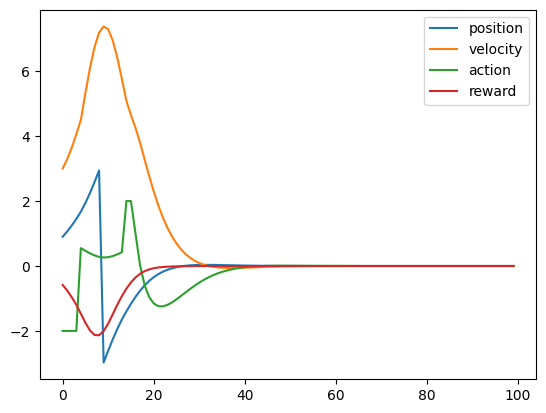

In [3]:
env = gym.make('CustomPendulum-v1')
pi = policy.PDPolicy(env)
buffer = mem.Memory()

s, _ = env.reset()
for t in range(100):
    #env.render()
    a = pi.get_action(s)
    s_new, rew, done, _ , _ = env.step(a)
    buffer.add_transition([s,a,rew,s_new, done])
    s = s_new

transitions = buffer.get_all_transitions()
states = np.vstack(transitions[:,0])
actions = transitions[:,1]
rewards = transitions[:,2]

plt.figure()
plt.plot(states[:,0], label="position")
plt.plot(states[:,1], label="velocity")
plt.plot(actions, label="action")
plt.plot(rewards, label="reward")
plt.legend()

for ep in range(500):
    s, _ = env.reset()
    for t in range(100):
        a = pi.get_action(s)
        s_new, rew, done, _, _ = env.step(a)
        buffer.add_transition([s,a,rew,s_new, done])
        s = s_new

buffer.size

### Define Value Function

In [4]:
class ValueFunction(Feedforward):
    def __init__(self, observation_dim, hidden_sizes=[100, 100]):
        # The V-Network is a fully connected network with 2 hidden layers of size 100 and tanh activation functions.
        # It takes the current observation as input and returns the action values of all available actions.
        super().__init__(input_size=observation_dim, hidden_sizes=hidden_sizes, output_size=1)
        # Adam is a state-of-the-art gradient-based optimizer commonly used for NN training.
        # For more information see Kingma & Ba, ADAM: A method for Stochastic Optimization
        # You can find the paper on arXiv: https://arxiv.org/pdf/1412.6980.pdf
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0005, eps=0.000001)
        self.loss = torch.nn.MSELoss()

    def fit(self, observations, targets):
        self.train()  # put model in training mode
        self.optimizer.zero_grad()
        # Forward pass
        pred = self.forward(torch.from_numpy(observations).float())
        # Compute Loss
        loss = self.loss(pred, torch.from_numpy(targets).float())
        # Backward pass
        loss.backward()
        self.optimizer.step()
        return loss.item()

### Learn Value Function

In [5]:
valuefunc = ValueFunction(observation_dim=2)
plt.show()

plt_fit = []

iter_fit = 1000
gamma = 0.95
for i in range(iter_fit):
    # sample from the replay buffer
    data = buffer.sample(batch=128)
    s = np.stack(data[:, 0])  # s_t
    sp = np.stack(data[:, 3])  # s_t+1
    rew = np.stack(data[:, 2])[:, None]  # rew

    values = valuefunc.predict(s)
    valuesp = valuefunc.predict(sp)
    # target
    td_target = rew + gamma * valuesp

    # optimize the lsq objective
    fit_loss = valuefunc.fit(s, td_target)
    plt_fit.append(fit_loss)

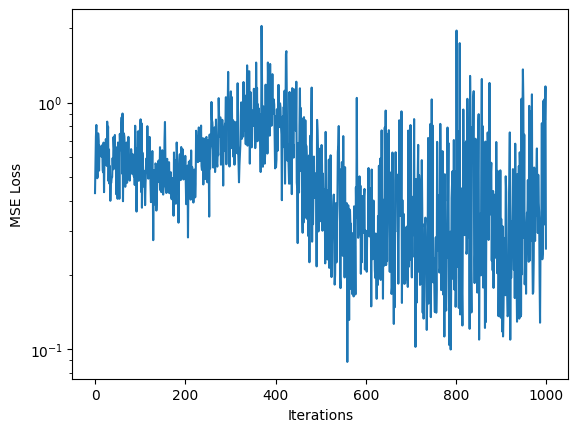

In [6]:
plot_loss(plt_fit)

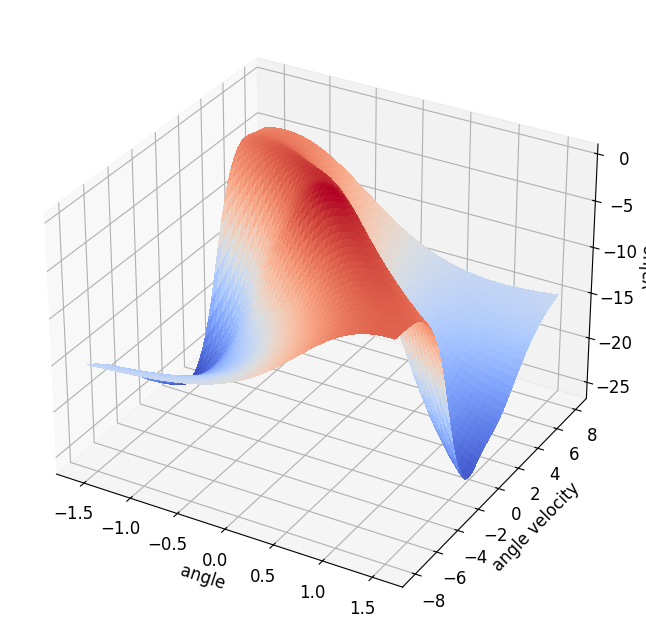

In [7]:
plot_value_function(valuefunc)